In [1]:
from SimPy.Simulation import *
import math
import random
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
def skipHeader(dataFile):
    dataFile.readline()
    dataFile.readline()
    dataFile.readline()
    dataFile.readline()
    
def readData(periods):
    for i in range(1,11):
        f = open('Project results' + str(i) + '.txt', 'r')
        skipHeader(f) #Skips the four header lines at the time of the file.

        arrivals = [] # Array of arrivals for a period of time
        departures = [] # Array of departures for a period of time
        startTime = float(f.readline()[0:-1].split('  ')[0])
        endTime = None

        for line in f:
            observation = line[0:-1].split('  ')
            if observation[1] == 'a':
                arrivals.append(float(observation[0]))
            elif observation[1] == 'd':
                departures.append(float(observation[0]))
            else:
                endTime = float(observation[0])

        periods.append([startTime, arrivals, departures, endTime])

In [3]:
periods = [] # Array containing periods of format [start time, arrivals, departures, end time]
readData(periods)

interArrivalTimes = []
for p in periods:
    for a in range(1, len(p[1])):
        interArrivalTimes.append(p[1][a] - p[1][a - 1])        
interArrivalBins = int(round(1 + np.log2(len(interArrivalTimes))))

#serviceTimes = []
#for p in periods:
#    for d in range(1, len(p[2])):
#        serviceTimes.append(p[2][d] - p[2][d - 1])
#serviceBins = int(round(1 + np.log2(len(serviceTimes))))

serviceTimes = []
for p in periods:
    serviceTimes.append(p[2][0]-p[1][0])
    for i in range(1,len(p[2])):
        if(p[2][i - 1] > p[1][i]):
            serviceTimes.append(p[2][i] - p[2][i - 1])
        else:
            serviceTimes.append(p[2][i] - p[1][i])
serviceBins = int(round(1 + np.log2(len(serviceTimes))))

Imean = np.mean(interArrivalTimes)
Smean = np.mean(serviceTimes)
print("mean inter-arrival time: ",Imean)
print("mean service time: ",Smean)

mean inter-arrival time:  58.28008368978102
mean service time:  42.50126948591549


In [4]:
## Model ##
class Source(Process):
    """generate random arrivals"""
    def run(self, N):
        for i in range(N):
            a = Arrival(str(i))
            activate(a, a.run())
            t = random.expovariate(1/Imean)
            
            G.interarrivalmon.observe(t)
            G.interarrivalsquaredmon.observe(t ** 2)
            yield hold, self, t

In [5]:
class Arrival(Process):
    """an arrival"""

    def run(self):
        G.inSystem += 1
        G.inQueue += 1
        arrivetime = now()
        G.LMon.observe(G.inSystem)
        G.LqMon.observe(G.inQueue)
        
        yield request, self, G.server
        
        G.inQueue -= 1
        G.LqMon.observe(G.inQueue)
        G.WqMon.observe(now() - arrivetime)
        
        t = random.expovariate(1/Smean)
        
        G.WsMon.observe(t)
        G.Ws2Mon.observe(t**2)
        
        yield hold, self, t
        yield release, self, G.server
        delay = now() - arrivetime
        G.WMon.observe(delay)
        
        G.inSystem -= 1
        G.LMon.observe(G.inSystem)

In [6]:
class G:
    inSystem = 0
    inQueue = 0
    
    server = 'dummy'
    
    WMon = 'Monitor'
    WsMon = 'Monitor'
    Ws2Mon = 'Monitor'
    WqMon = 'Monitor'
    LMon = 'Monitor'
    LqMon = 'Monitor'
    interarrivalmon = 'Monitor'
    interarrivalsquaredmon = 'Monitor'
    
    serviceTimes = []
    interArrivalTimes = []

In [7]:
def model(c, N, maxtime, rvseed):
    # setup
    initialize()
    random.seed(rvseed)
    G.inSystem = 0
    G.inQueue = 0
    
    G.server = Resource(1, monitored=True)
    G.WMon = Monitor()
    G.WsMon = Monitor()
    G.Ws2Mon = Monitor()
    G.WqMon = Monitor()
    G.LMon = Monitor()
    G.LqMon = Monitor()
    
    G.interarrivalmon = Monitor()
    G.interarrivalsquaredmon = Monitor()

    # simulate
    s = Source('Source')
    activate(s, s.run(N))
    simulate(until=maxtime)

    # gather performance measures
    W = G.WMon.mean()
    Ws = G.WsMon.mean()
    Ws2 = G.Ws2Mon.mean()
    Wq = G.WqMon.mean()
    L = G.LMon.timeAverage()
    Lq = G.LqMon.timeAverage()
    
    Svar = G.WsMon.var()
    util = G.server.actMon.timeAverage()
    IA = G.interarrivalmon.mean()
    IAvar = G.interarrivalmon.var()

    G.serviceTimes += G.WsMon.yseries()
    G.interArrivalTimes += G.interarrivalmon.yseries()

    return(W,Ws,Ws2,L,util,IA,Wq,Lq,IAvar,Svar)

In [8]:
## Experiment ##

allW = []
allWq = []
allS = []
allL = []
allLq = []
allUtil = []
allIA = []
allIAvar = []
allSvar = []

for i in range(50):
    if i == 9:
        print("Doing", str(i + 1) + "th", "iteration")
    elif i == 19:
        print("Doing", str(i + 1) + "th", "iteration")
    elif i == 29:
        print("Doing", str(i + 1) + "th", "iteration")
    elif i ==39:
        print("Doing", str(i + 1) + "th", "iteration")
        
    result = model(c=1, N=30, maxtime=2000000000, rvseed=123*i)
    
    allW.append(result[0])
    allS.append(result[1])
    allL.append(result[3])
    allUtil.append(result[4])
    allIA.append(result[5])
    allWq.append(result[6])
    allLq.append(result[7])
    allIAvar.append(result[8])
    allSvar.append(result[9])

print("")
print(" PERFORMANCE ESTIMATES: ")
print("---------")
print("Interarrival mean:", np.mean(allIA))
print("W:", np.mean(allW))
print("Wq:", np.mean(allWq))
print("Ws:", np.mean(allS))
print("L:", np.mean(allL))
print("Lq:", np.mean(allLq))
print("Utilisation :", np.mean(allUtil))
print("Interarrival variance :", np.mean(allIAvar))
print("Ws variance :", np.mean(allSvar))

Doing 10th iteration
Doing 20th iteration
Doing 30th iteration
Doing 40th iteration

 PERFORMANCE ESTIMATES: 
---------
Interarrival mean: 58.63156961553718
W: 116.96505241169457
Wq: 74.30212204550605
Ws: 42.66293036618851
L: 1.9131311849735306
Lq: 1.2158972168467197
Utilisation : 0.6972339681268107
Interarrival variance : 3388.5995949226053
Ws variance : 1839.6098065240515


In [9]:
serviceTimes = G.serviceTimes
interArrivalTimes = G.interArrivalTimes

serviceBins = int(round(1 + np.log2(len(serviceTimes))))
interArrivalBins = int(round(1 + np.log2(len(interArrivalTimes))))

Service Times:

[12.735178660782143, 22.06169438237532, 15.36075115773595, 37.21350119598076, 29.85990872807323, 59.917649375645034, 12.255556511979508, 172.64023464443093, 98.79346171747866]


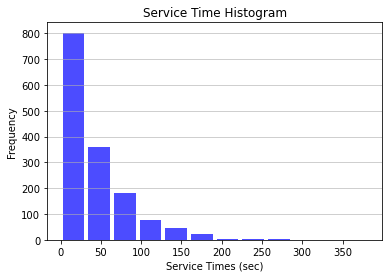

In [10]:
#Service Histogram
plt.hist(x=serviceTimes, bins=serviceBins, color='blue', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Service Times (sec)')
plt.ylabel('Frequency')
plt.title('Service Time Histogram')
plot = plt.plot();
sample = serviceTimes[1:10]
print("Service Times:\n")
print(sample)

interarival times:

[31.80420779277768, 41.725902734525775, 89.25856189247105, 37.730728386621074, 139.12589339762698, 19.294198210822582, 56.141268557360405, 140.17118919588754, 96.85422622125003]


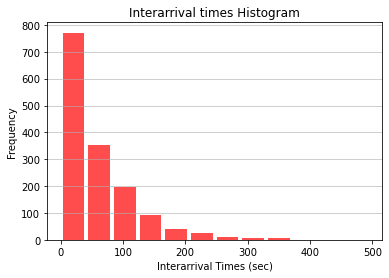

In [11]:
#Interarrival Histogram
plt.hist(x=interArrivalTimes, bins=interArrivalBins, color='red', alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Interarrival Times (sec)')
plt.ylabel('Frequency')
plt.title('Interarrival times Histogram')
plot2 = plt.plot();
sample2 = interArrivalTimes[1:10]
print("interarival times:\n")
print(sample2)